## Import Library

In [19]:
# Import libraries
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

## Mount Google Drive
Mengakses Dataset

In [20]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Pemisahan Dataset dan Augmentasi Data



In [21]:
# Lokasi Dataset
train_dir = '/content/drive/MyDrive/PI/train_mclahe'
val_dir = '/content/drive/MyDrive/PI/valid_mclahe'
test_dir = '/content/drive/MyDrive/PI/test_mclahe'

# Generator untuk data pelatihan dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,             # Lebih kecil untuk mempertahankan konteks
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generator untuk data validasi dan uji tanpa augmentasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Data pelatihan
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=True,
    class_mode='binary'
)

# Data validasi
val_data = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

Found 1538 images belonging to 2 classes.
Found 440 images belonging to 2 classes.


## Visualisasi Dataset
Menampilkan beberapa gambar dari dataset untuk melihat hasil augmentasi :

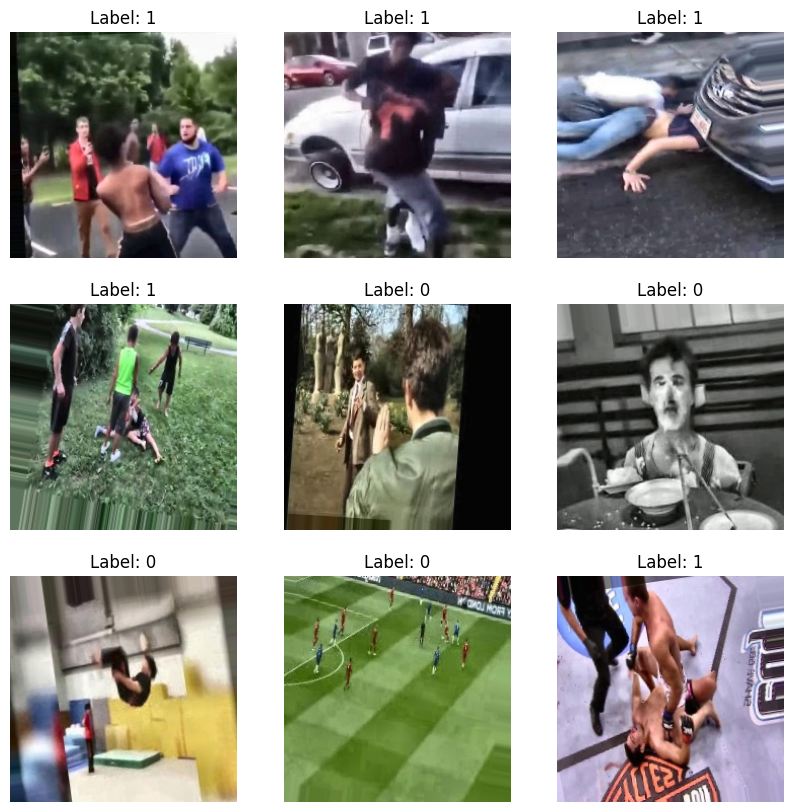

In [22]:
# Visualisasi data pelatihan
def visualize_data(data):
    images, labels = next(data)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(f"Label: {int(labels[i])}")
        plt.axis('off')
    plt.show()

visualize_data(train_data)

## Membangun Model
Menggunakan model VGG16 yang telah dilatih sebelumnya dengan modifikasi :

In [23]:
# Load VGG16 pre-trained model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Full Freeze
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = models.Sequential([
    base_model,  # Menambahkan VGG16
    layers.GlobalAveragePooling2D(),  # Pooling layer
    # First fully connected layer
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Second fully connected layer
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

checkpoint = ModelCheckpoint(
    'MCLAHE_FreezeAll_0.0001.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,112,001 (57.65 MB)

 Trainable params: 395,777 (1.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

## Melatih Model
Melakukan pelatihan model dengan data pelatihan dan validasi:

In [24]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.5905 - loss: 1.4051
Epoch 1: val_accuracy improved from -inf to 0.59773, saving model to MCLAHE_FreezeAll_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 615ms/step - accuracy: 0.5911 - loss: 1.4032 - val_accuracy: 0.5977 - val_loss: 1.1337
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.7119 - loss: 1.1193
Epoch 2: val_accuracy did not improve from 0.59773
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 546ms/step - accuracy: 0.7120 - loss: 1.1192 - val_accuracy: 0.5295 - val_loss: 1.1075
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.7430 - loss: 1.0068
Epoch 3: val_accuracy did not improve from 0.59773
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 546ms/step - accuracy: 0.7431 - loss: 1.0065 - val_accuracy: 0.5364 - val_loss: 1.0858
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.7728 - loss: 0.9157
Epoch 4: val_accuracy did not improve from 0.59773
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 541ms/step - accuracy: 0.7729 - loss: 0.9163 - val_accuracy: 0.5795 - val_loss: 1.0350
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.7915 - loss: 0.8744
Epoch 5: val_accuracy improved 

49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 543ms/step - accuracy: 0.7913 - loss: 0.8746 - val_accuracy: 0.6591 - val_loss: 0.9504
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.7997 - loss: 0.8421
Epoch 6: val_accuracy improved from 0.65909 to 0.76136, saving model to MCLAHE_FreezeAll_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 549ms/step - accuracy: 0.7998 - loss: 0.8419 - val_accuracy: 0.7614 - val_loss: 0.8558
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.8121 - loss: 0.8224
Epoch 7: val_accuracy improved from 0.76136 to 0.78864, saving model to MCLAHE_FreezeAll_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 551ms/step - accuracy: 0.8121 - loss: 0.8222 - val_accuracy: 0.7886 - val_loss: 0.7911
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.8339 - loss: 0.7583
Epoch 8: val_accuracy improved from 0.78864 to 0.85000, saving model to MCLAHE_FreezeAll_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 546ms/step - accuracy: 0.8338 - loss: 0.7584 - val_accuracy: 0.8500 - val_loss: 0.7205
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.8445 - loss: 0.7441
Epoch 9: val_accuracy improved from 0.85000 to 0.86591, saving model to MCLAHE_FreezeAll_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 42s 564ms/step - accuracy: 0.8443 - loss: 0.7443 - val_accuracy: 0.8659 - val_loss: 0.6673
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.8383 - loss: 0.7246
Epoch 10: val_accuracy improved from 0.86591 to 0.86818, saving model to MCLAHE_FreezeAll_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 564ms/step - accuracy: 0.8381 - loss: 0.7250 - val_accuracy: 0.8682 - val_loss: 0.6446
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.8370 - loss: 0.7504
Epoch 11: val_accuracy did not improve from 0.86818
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 551ms/step - accuracy: 0.8369 - loss: 0.7503 - val_accuracy: 0.8614 - val_loss: 0.6392
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.8345 - loss: 0.7089
Epoch 12: val_accuracy improved from 0.86818 to 0.87045, saving model to MCLAHE_FreezeAll_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 563ms/step - accuracy: 0.8347 - loss: 0.7088 - val_accuracy: 0.8705 - val_loss: 0.6186
Epoch 13/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.8432 - loss: 0.7131
Epoch 13: val_accuracy improved from 0.87045 to 0.87955, saving model to MCLAHE_FreezeAll_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 564ms/step - accuracy: 0.8433 - loss: 0.7132 - val_accuracy: 0.8795 - val_loss: 0.6006
Epoch 14/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.8441 - loss: 0.7000
Epoch 14: val_accuracy improved from 0.87955 to 0.89545, saving model to MCLAHE_FreezeAll_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 560ms/step - accuracy: 0.8443 - loss: 0.6998 - val_accuracy: 0.8955 - val_loss: 0.5889
Epoch 15/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.8532 - loss: 0.6758
Epoch 15: val_accuracy did not improve from 0.89545
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 551ms/step - accuracy: 0.8532 - loss: 0.6760 - val_accuracy: 0.8909 - val_loss: 0.5851
Epoch 16/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.8628 - loss: 0.6585
Epoch 16: val_accuracy did not improve from 0.89545
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 554ms/step - accuracy: 0.8629 - loss: 0.6583 - val_accuracy: 0.8955 - val_loss: 0.5732
Epoch 17/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.8508 - loss: 0.6821
Epoch 17: val_accuracy improved from 0.89545 to 0.89773, saving model to MCLAHE_FreezeAll_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 555ms/step - accuracy: 0.8507 - loss: 0.6820 - val_accuracy: 0.8977 - val_loss: 0.5603
Epoch 18/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.8843 - loss: 0.6155
Epoch 18: val_accuracy did not improve from 0.89773
49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 530ms/step - accuracy: 0.8842 - loss: 0.6156 - val_accuracy: 0.8932 - val_loss: 0.5629
Epoch 19/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.8768 - loss: 0.6423
Epoch 19: val_accuracy improved from 0.89773 to 0.90682, saving model to MCLAHE_FreezeAll_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 42s 560ms/step - accuracy: 0.8768 - loss: 0.6423 - val_accuracy: 0.9068 - val_loss: 0.5563
Epoch 20/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.8731 - loss: 0.6335
Epoch 20: val_accuracy improved from 0.90682 to 0.91136, saving model to MCLAHE_FreezeAll_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 562ms/step - accuracy: 0.8729 - loss: 0.6335 - val_accuracy: 0.9114 - val_loss: 0.5513
Epoch 21/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.8820 - loss: 0.6358
Epoch 21: val_accuracy did not improve from 0.91136
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 553ms/step - accuracy: 0.8819 - loss: 0.6354 - val_accuracy: 0.8977 - val_loss: 0.5447
Epoch 22/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.8757 - loss: 0.6166
Epoch 22: val_accuracy did not improve from 0.91136
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 562ms/step - accuracy: 0.8758 - loss: 0.6164 - val_accuracy: 0.9000 - val_loss: 0.5513
Epoch 23/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.8876 - loss: 0.5809
Epoch 23: val_accuracy did not improve from 0.91136
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 553ms/step - accuracy: 0.8875 - loss: 0.5814 - val_accuracy: 0.9091 - val_loss: 0.5446
Epoch 24/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.8729 - loss: 0.6094
Epoch 24: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 561ms/step - accuracy: 0.8989 - loss: 0.5414 - val_accuracy: 0.9205 - val_loss: 0.4968
Epoch 35/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.9083 - loss: 0.5576
Epoch 35: val_accuracy did not improve from 0.92045
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 554ms/step - accuracy: 0.9082 - loss: 0.5575 - val_accuracy: 0.9159 - val_loss: 0.5021
Epoch 36/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.8775 - loss: 0.5681
Epoch 36: val_accuracy did not improve from 0.92045
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 553ms/step - accuracy: 0.8777 - loss: 0.5679 - val_accuracy: 0.9205 - val_loss: 0.4995
Epoch 37/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.8803 - loss: 0.5673
Epoch 37: val_accuracy did not improve from 0.92045
49/49 ━━━━━━━━━━━━━━━━━━━━ 43s 592ms/step - accuracy: 0.8805 - loss: 0.5671 - val_accuracy: 0.9159 - val_loss: 0.4956
Epoch 38/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.8814 - loss: 0.5525
Epoch 38: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 559ms/step - accuracy: 0.9225 - loss: 0.4820 - val_accuracy: 0.9227 - val_loss: 0.4850
Epoch 42/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.9121 - loss: 0.5107
Epoch 42: val_accuracy improved from 0.92273 to 0.92500, saving model to MCLAHE_FreezeAll_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 556ms/step - accuracy: 0.9120 - loss: 0.5105 - val_accuracy: 0.9250 - val_loss: 0.4841
Epoch 43/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.9032 - loss: 0.5102
Epoch 43: val_accuracy did not improve from 0.92500
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 557ms/step - accuracy: 0.9031 - loss: 0.5104 - val_accuracy: 0.9182 - val_loss: 0.4903
Epoch 44/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.9076 - loss: 0.5095
Epoch 44: val_accuracy did not improve from 0.92500
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 551ms/step - accuracy: 0.9076 - loss: 0.5094 - val_accuracy: 0.9091 - val_loss: 0.4864
Epoch 45/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.9166 - loss: 0.4789
Epoch 45: val_accuracy did not improve from 0.92500
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 553ms/step - accuracy: 0.9165 - loss: 0.4792 - val_accuracy: 0.9182 - val_loss: 0.4770
Epoch 46/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.9067 - loss: 0.5112
Epoch 46: val_accuracy d

## Visualisasi Akurasi dan Loss
Menampilkan grafik akurasi dan loss selama pelatihan:

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.9163 - loss: 0.4545
Validation Loss: 0.4779887795448303
Validation Accuracy: 0.9159091114997864


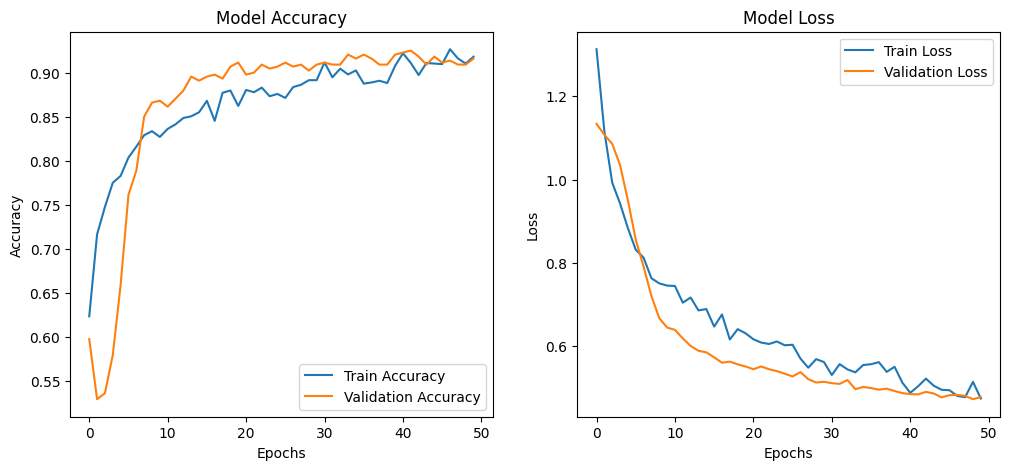

In [25]:
# 2. Evaluasi model pada data validasi
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Plot training and validation metrics
def plot_metrics(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_metrics(history)

In [26]:
# Data uji
test_data = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

# Muat model dengan val_accuracy tertinggi
best_model = load_model('MCLAHE_FreezeAll_0.0001.h5')

# Evaluasi pada test set
test_loss, test_acc = best_model.evaluate(test_data, verbose=1)
print("Test Accuracy : {:.2f}%".format(test_acc * 100))
print("Test Loss     : {:.3f}".format(test_loss))

Found 222 images belonging to 2 classes.


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.8909 - loss: 0.6008
Test Accuracy : 91.89%
Test Loss     : 0.524


## Evaluasi Model
Menghitung confusion matrix dan tampilkan classification report:

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 257ms/step


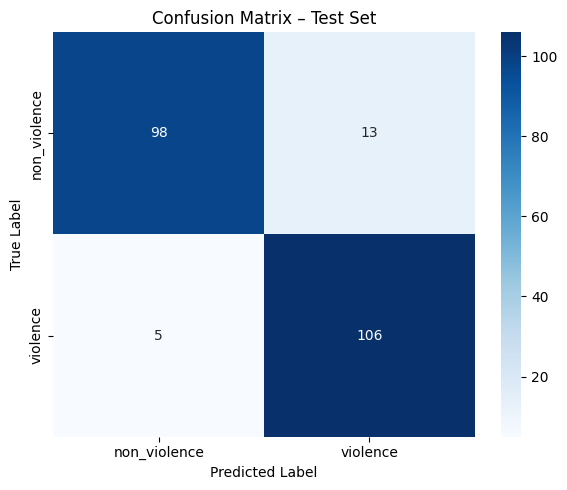


Classification Report (Test Set):
              precision    recall  f1-score   support

non_violence       0.95      0.88      0.92       111
    violence       0.89      0.95      0.92       111

    accuracy                           0.92       222
   macro avg       0.92      0.92      0.92       222
weighted avg       0.92      0.92      0.92       222



In [27]:
# -------------------------------------------------------------
# 1) Buat prediksi pada TEST SET dengan model terbaik
# -------------------------------------------------------------
test_pred_prob   = best_model.predict(test_data, verbose=1)  # ← ganti 'model' → 'best_model'
test_pred_labels = (test_pred_prob > 0.5).astype("int32").flatten()

# -------------------------------------------------------------
# 2) Label asli dan nama kelas
# -------------------------------------------------------------
true_test_labels = test_data.classes
class_names      = list(test_data.class_indices.keys())

# -------------------------------------------------------------
# 3) Confusion Matrix
# -------------------------------------------------------------
cm = confusion_matrix(true_test_labels, test_pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix – Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 4) Classification Report
# -------------------------------------------------------------
print("\nClassification Report (Test Set):")
print(classification_report(true_test_labels,
                            test_pred_labels,
                            target_names=class_names,
                            digits=2))